### Parameter $\theta$ Estimation with Particle MCMC

#### Pre-conditioned Crank Nicolson. We need two parameters K and beta, which together decide the step size or model complexity.

Processing: 100%|██████████| 10/10 [11:22<00:00, 68.22s/it]


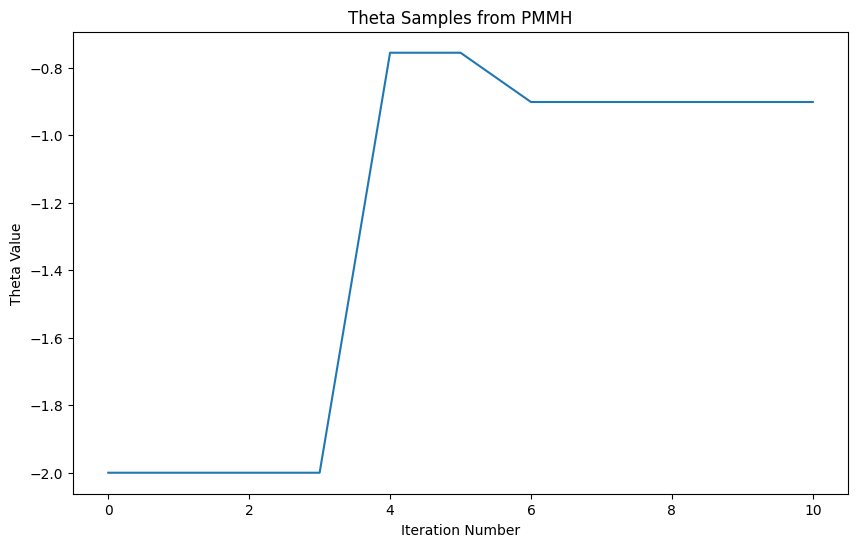

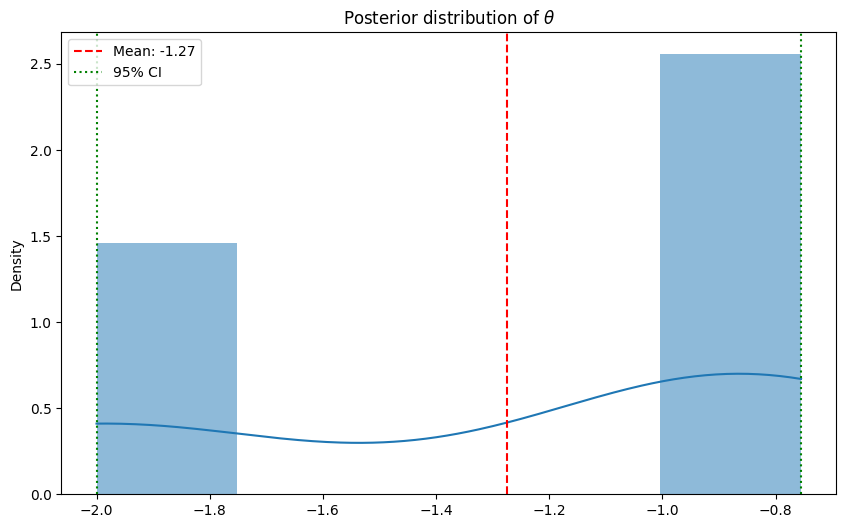

Mean of theta: -1.2742392592425853
Median of theta: -0.9012589636451735
95% confidence interval of theta: [-2.         -0.75516852]


In [6]:
import numpy as np
from scipy.linalg import expm #This is the automatic matrix expnent solver
from jump_process_generators import *
import matplotlib.pyplot as plt
from NVM_state_space import *
from NVM_state_space_filters import *
from basic_tools import *
from scipy.special import logsumexp
from tqdm import tqdm  # 导入tqdm
import seaborn as sns
#Again, we first generate the noisy observations.
#We again have the noisy data first:
#Again, we first generate the noisy observations.
#We again have the noisy data first:


#beta_pcn = 1 #The step parameter for the pre-conditioned crank nicolson algorithm
n_iter = 10 #Number of iterations
theta0 = -2 #Initial guess of theta
num_particles = 100
l = 1 #Step size
K = l**2 # Squared length of the Gaussian "kernel". Since in this case our space is 1D, K is just the Gaussian variance.




true_theta = -1 #The true theta value for the Langevin system


kw = 1 #The prior parameter for muw

kv = 0.001 #The observation noise scaling factor. Note that this scaling factor applies to the variance
true_sigmaw = 2
true_muw = 0.2
sigma_n = true_sigmaw * np.sqrt(kv)


#Simulation Parameters

beta = 5
C = 10
T = 100


N = 1000  # Resolution

#Define the Langevin dynamics
A = np.zeros((2, 2))
A[0, 1] = 1
A[1, 1] = true_theta
h = np.array([[0], [1]])

#Simulation
evaluation_points = np.linspace(0, T, N) #Note that this would be the time axis we work on.
normal_gamma_generator = normal_gamma_process(beta, C, T, true_muw, true_sigmaw)
langevin = SDE(A,h,T,normal_gamma_generator)
#Noisy observation generation
SDE_samples,system_jumps,NVM_jumps,subordinator_jumps,jump_times = langevin.generate_samples(evaluation_points,all_data=True)
d1,d2 = np.shape(SDE_samples)
#Noisy_samples = SDE_samples + np.random.randn(d1,d2)*sigma_n #The noisy observations simulated. Already in the column vector form


#Create the partial observation, observing only the integral state x here.
Noisy_samples = SDE_samples[:,0] + np.random.randn(np.shape(SDE_samples)[0])*sigma_n #The noisy observations simulated. Already in the column vector form

theta_samples = [theta0]
first_time = True

for iter in tqdm(range(n_iter), desc="Processing"):



    if first_time:
        #print("Progress:",progress/searching_resolution, "%")
        #progress +=1
        #Prior inverted gamma parameters for sigmaw
        alphaws = 2.1 * np.ones(num_particles)
        betaws = 1 * np.ones(num_particles)
        accumulated_Es = np.zeros(num_particles)
        accumulated_Fs = np.zeros(num_particles)

        trajectory = []
        A = np.zeros((2, 2))
        A[0, 1] = 1
        A[1, 1] = theta_samples[-1]

        #Kalman filter initialisation
        X0 = Noisy_samples[0]
        nx0 = 2
        X0 = np.zeros((nx0+1,1))
        nx0_new = 3

        #The margianlised Kalman covariance
        C_prior = np.zeros((nx0_new,nx0_new))
        C_prior[-1,-1] = kw

        g = np.array([[1],[0],[0]])
        g = g.T
        R = np.array([kv]) #The noise covariance matrix. Same observation noise throughout




        #Particle filter Initialisation    
        initial_particles = []
        for i in range(num_particles):
            initial_particles.append([np.zeros((nx0,1)),np.eye(nx0)])
        previous_Xs = []
        previous_X_uncertaintys = []
        for i in range(num_particles):
            previous_X_uncertaintys.append(C_prior)
            previous_Xs.append(X0)
        # Define initial weights (uniform)
        initial_weights = np.ones(num_particles) / num_particles

        

        # Time step size and sigma for the likelihood function
        dt = evaluation_points[1] - evaluation_points[0]
        matrix_exp = expm(A*dt)
        sigma = sigma_n #The observatin noise



        #Containers for the imnference results
        inferred_Xs = []
        inferred_covs = []
        first_time = True

        # Running the particle filter
        particles = initial_particles
        histories = [particles]
        weights = initial_weights




        sigmaw_values = []
        sigmaw_uncertainties = []

        for i in range(len(evaluation_points)): #i is the time index we want for N
            #sigmaw here needs to be updated in every step
            alphaw = weighted_sum(alphaws,weights)
            betaw = weighted_sum(betaws,weights)
            sigmaw2,sigmaw_uncertainty = inverted_gamma_to_mean_variance(alphaw, betaw) #Note that this is sigmaw^2 but not sigmaw
            sigmaw = np.sqrt(sigmaw2)

            sigmaw_values.append(sigmaw)
            sigmaw_uncertainties.append(sigmaw_uncertainty)


            incremental_normal_gamma_generator = normal_gamma_process(beta, C, dt, 0, sigmaw) #We are just using the built in gamma generator inside， putting in some random muw or sigmaw has no effect
            incremental_SDE = SDE(A,h,dt,incremental_normal_gamma_generator)
            #print(i)
            t = evaluation_points[i]
            observation = Noisy_samples[i] #Note that the observation here is still a row vector, reshaping necessary
            previous_Xs, previous_X_uncertaintys,particles,weights,alphaws, betaws, accumulated_Es, accumulated_Fs,log_marginals  = ultimate_NVM_pf(observation, previous_Xs, previous_X_uncertaintys, particles, transition_function_ultimate_NVM_pf, matrix_exp, dt,incremental_SDE,g,R,alphaws,betaws,accumulated_Es,accumulated_Fs,i,return_log_marginals=True) # N is the time nidex
            inferred_cov = weighted_sum(previous_X_uncertaintys,weights) * sigmaw2 #Note that the original parameters are marginalised by sigmaw^2
            inferred_X = weighted_sum(previous_Xs,weights)
            
            histories.append(particles)
            
            inferred_Xs.append(inferred_X)
            inferred_covs.append(inferred_cov)
            log_marginals = np.array(log_marginals)

        original_state_log_probability = logsumexp(log_marginals) - np.log(num_particles)
        first_time = False

    #####################################################################################################################################################################################################################################################
    #From here, we propose a theta sample

    theta_proposed = theta_samples[-1] + np.random.randn() * l

    #print("Progress:",progress/searching_resolution, "%")
    #progress +=1
    #Prior inverted gamma parameters for sigmaw
    alphaws = 2.1 * np.ones(num_particles)
    betaws = 1 * np.ones(num_particles)
    accumulated_Es = np.zeros(num_particles)
    accumulated_Fs = np.zeros(num_particles)

    trajectory = []
    A = np.zeros((2, 2))
    A[0, 1] = 1
    A[1, 1] = theta_proposed

    #Kalman filter initialisation
    X0 = Noisy_samples[0]
    nx0 = 2
    X0 = np.zeros((nx0+1,1))
    nx0_new = 3

    #The margianlised Kalman covariance
    C_prior = np.zeros((nx0_new,nx0_new))
    C_prior[-1,-1] = kw

    g = np.array([[1],[0],[0]])
    g = g.T
    R = np.array([kv]) #The noise covariance matrix. Same observation noise throughout




    #Particle filter Initialisation    
    initial_particles = []
    for i in range(num_particles):
        initial_particles.append([np.zeros((nx0,1)),np.eye(nx0)])
    previous_Xs = []
    previous_X_uncertaintys = []
    for i in range(num_particles):
        previous_X_uncertaintys.append(C_prior)
        previous_Xs.append(X0)
    # Define initial weights (uniform)
    initial_weights = np.ones(num_particles) / num_particles

    

    # Time step size and sigma for the likelihood function
    dt = evaluation_points[1] - evaluation_points[0]
    matrix_exp = expm(A*dt)
    sigma = sigma_n #The observatin noise



    #Containers for the imnference results
    inferred_Xs = []
    inferred_covs = []
    first_time = True

    # Running the particle filter
    particles = initial_particles
    histories = [particles]
    weights = initial_weights




    sigmaw_values = []
    sigmaw_uncertainties = []

    for i in range(len(evaluation_points)): #i is the time index we want for N
        #sigmaw here needs to be updated in every step
        alphaw = weighted_sum(alphaws,weights)
        betaw = weighted_sum(betaws,weights)
        sigmaw2,sigmaw_uncertainty = inverted_gamma_to_mean_variance(alphaw, betaw) #Note that this is sigmaw^2 but not sigmaw
        sigmaw = np.sqrt(sigmaw2)

        sigmaw_values.append(sigmaw)
        sigmaw_uncertainties.append(sigmaw_uncertainty)


        incremental_normal_gamma_generator = normal_gamma_process(beta, C, dt, 0, sigmaw) #We are just using the built in gamma generator inside， putting in some random muw or sigmaw has no effect
        incremental_SDE = SDE(A,h,dt,incremental_normal_gamma_generator)
        #print(i)
        t = evaluation_points[i]
        observation = Noisy_samples[i] #Note that the observation here is still a row vector, reshaping necessary
        previous_Xs, previous_X_uncertaintys,particles,weights,alphaws, betaws, accumulated_Es, accumulated_Fs,log_marginals  = ultimate_NVM_pf(observation, previous_Xs, previous_X_uncertaintys, particles, transition_function_ultimate_NVM_pf, matrix_exp, dt,incremental_SDE,g,R,alphaws,betaws,accumulated_Es,accumulated_Fs,i,return_log_marginals=True) # N is the time nidex
        inferred_cov = weighted_sum(previous_X_uncertaintys,weights) * sigmaw2 #Note that the original parameters are marginalised by sigmaw^2
        inferred_X = weighted_sum(previous_Xs,weights)
        
        histories.append(particles)
        
        inferred_Xs.append(inferred_X)
        inferred_covs.append(inferred_cov)
        log_marginals = np.array(log_marginals)

    proposed_state_log_probability = logsumexp(log_marginals) - np.log(num_particles)


    ##################################################################################################################################################################################################################################
    # Acceptance Attempt
    log_acceptance_ratio = proposed_state_log_probability - original_state_log_probability
    if np.log(np.random.rand())< log_acceptance_ratio: #Accepted case
        theta_samples.append(theta_proposed)
        original_state_log_probability = proposed_state_log_probability
    else: #Rejected case
        theta_samples.append(theta_samples[-1])



theta_samples = np.array(theta_samples)  # 假设已经去除了燃烧期的样本

# 后验分布摘要
mean_theta = np.mean(theta_samples)
median_theta = np.median(theta_samples)
conf_interval = np.percentile(theta_samples, [2.5, 97.5])  # 95%置信区间

plt.figure(figsize=(10, 6))
plt.plot(theta_samples)
plt.xlabel("Iteration Number")
plt.ylabel("Theta Value")
plt.title("Theta Samples from PMMH")
plt.show()

# 可视化后验分布
plt.figure(figsize=(10, 6))
sns.histplot(theta_samples, kde=True, stat="density", linewidth=0)
plt.axvline(mean_theta, color='r', linestyle='--', label=f'Mean: {mean_theta:.2f}')
plt.axvline(conf_interval[0], color='g', linestyle=':', label='95% CI')
plt.axvline(conf_interval[1], color='g', linestyle=':')
plt.title('Posterior distribution of $\\theta$')
plt.legend()
plt.show()

# 打印摘要统计量
print(f"Mean of theta: {mean_theta}")
print(f"Median of theta: {median_theta}")
print(f"95% confidence interval of theta: {conf_interval}")

In [7]:
def autocorrelation(samples):
    n = len(samples)
    mean = np.mean(samples)
    var = np.var(samples, ddof=0)
    acf = np.correlate(samples - mean, samples - mean, mode='full')[n-1:] / (var*n)
    return acf

def plot_autocorrelation(samples, max_lag=20):
    sample_length = np.size(samples)
    if sample_length < 40:
        max_lag = sample_length-1
    acf = autocorrelation(samples)[:max_lag+1]
    time_lags = np.arange(max_lag+1)
    plt.figure(figsize=(10, 6))
    plt.stem(time_lags, acf, linefmt='-', markerfmt='o', basefmt=" ")
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.title('Autocorrelation Function')
    plt.grid(True)
    plt.show()

    # Estimate the autocorrelation time
    act = 1 + 2 * np.sum(acf[1:])
    print(f"Estimated Autocorrelation Time: {act}")

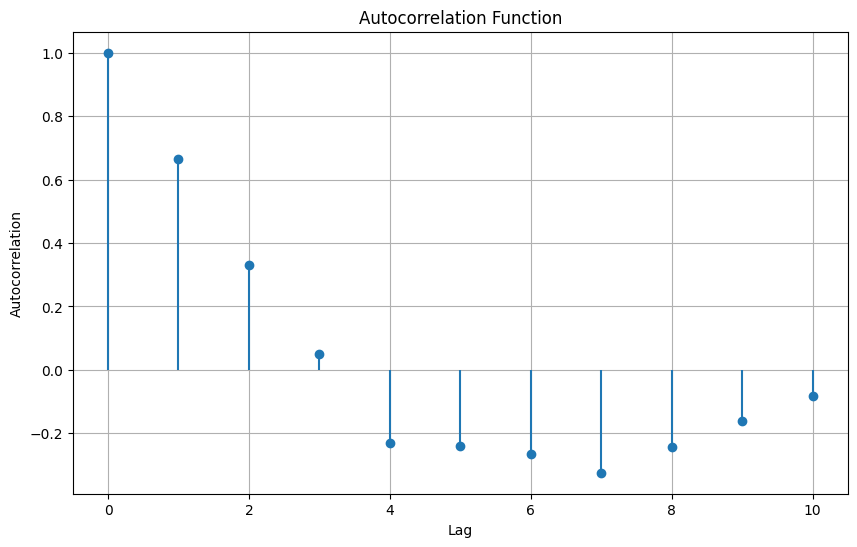

Estimated Autocorrelation Time: -2.220446049250313e-16


In [8]:
plot_autocorrelation(theta_samples)

Processing: 100%|██████████| 300/300 [5:33:50<00:00, 66.77s/it]  


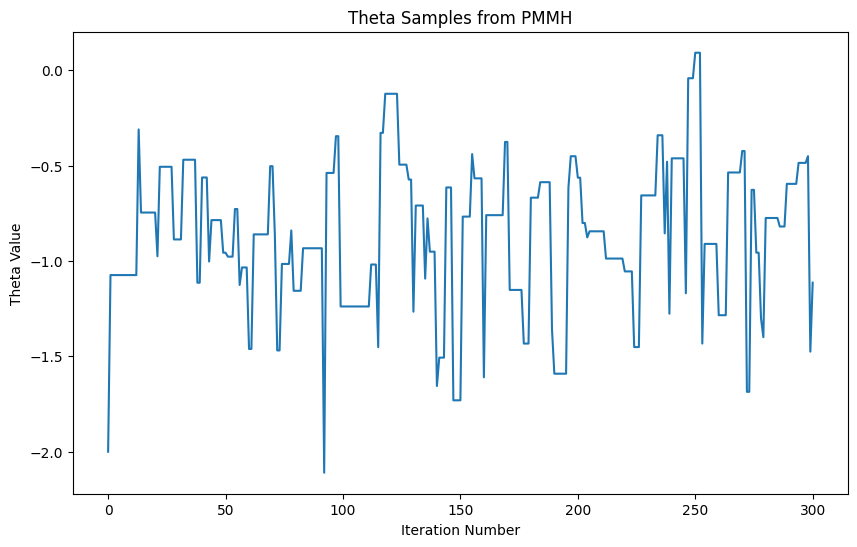

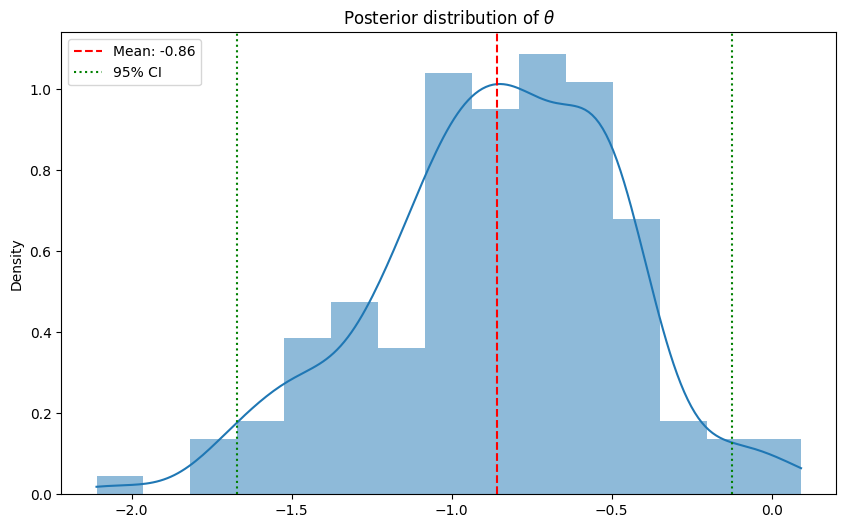

Mean of theta: -0.8571821955805581
Median of theta: -0.8444225246356393
95% confidence interval of theta: [-1.67070292 -0.12339584]


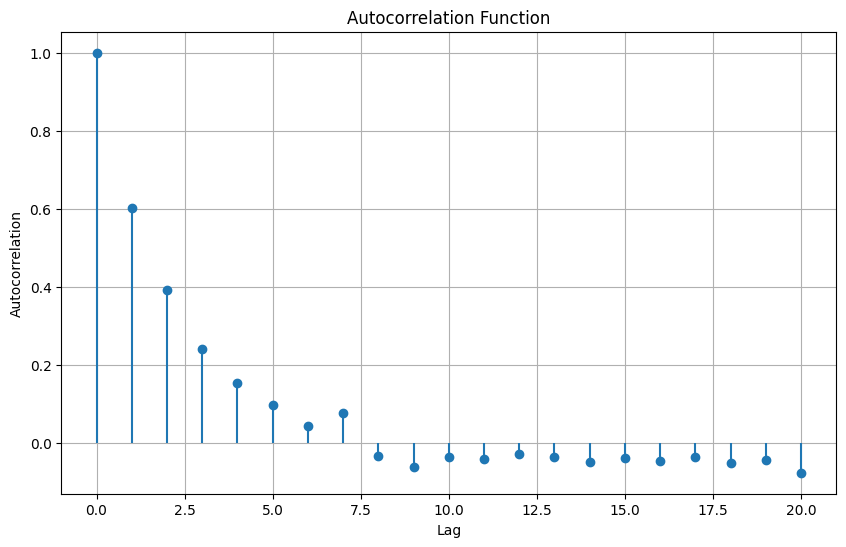

Estimated Autocorrelation Time: 3.09364388739739


In [2]:
import numpy as np
from scipy.linalg import expm #This is the automatic matrix expnent solver
from jump_process_generators import *
import matplotlib.pyplot as plt
from NVM_state_space import *
from NVM_state_space_filters import *
from basic_tools import *
from scipy.special import logsumexp
from tqdm import tqdm  # 导入tqdm
import seaborn as sns
#Again, we first generate the noisy observations.
#We again have the noisy data first:
#Again, we first generate the noisy observations.
#We again have the noisy data first:


#beta_pcn = 1 #The step parameter for the pre-conditioned crank nicolson algorithm
n_iter = 300 #Number of iterations
theta0 = -2 #Initial guess of theta
num_particles = 100
l = 1 #Step size
K = l**2 # Squared length of the Gaussian "kernel". Since in this case our space is 1D, K is just the Gaussian variance.




true_theta = -1 #The true theta value for the Langevin system


kw = 1 #The prior parameter for muw

kv = 0.001 #The observation noise scaling factor. Note that this scaling factor applies to the variance
true_sigmaw = 2
true_muw = 0.2
sigma_n = true_sigmaw * np.sqrt(kv)


#Simulation Parameters

beta = 5
C = 10
T = 100


N = 1000  # Resolution

#Define the Langevin dynamics
A = np.zeros((2, 2))
A[0, 1] = 1
A[1, 1] = true_theta
h = np.array([[0], [1]])

#Simulation
evaluation_points = np.linspace(0, T, N) #Note that this would be the time axis we work on.
normal_gamma_generator = normal_gamma_process(beta, C, T, true_muw, true_sigmaw)
langevin = SDE(A,h,T,normal_gamma_generator)
#Noisy observation generation
SDE_samples,system_jumps,NVM_jumps,subordinator_jumps,jump_times = langevin.generate_samples(evaluation_points,all_data=True)
d1,d2 = np.shape(SDE_samples)
#Noisy_samples = SDE_samples + np.random.randn(d1,d2)*sigma_n #The noisy observations simulated. Already in the column vector form


#Create the partial observation, observing only the integral state x here.
Noisy_samples = SDE_samples[:,0] + np.random.randn(np.shape(SDE_samples)[0])*sigma_n #The noisy observations simulated. Already in the column vector form

theta_samples = [theta0]
first_time = True

for iter in tqdm(range(n_iter), desc="Processing"):



    if first_time:
        #print("Progress:",progress/searching_resolution, "%")
        #progress +=1
        #Prior inverted gamma parameters for sigmaw
        alphaws = 2.1 * np.ones(num_particles)
        betaws = 1 * np.ones(num_particles)
        accumulated_Es = np.zeros(num_particles)
        accumulated_Fs = np.zeros(num_particles)

        trajectory = []
        A = np.zeros((2, 2))
        A[0, 1] = 1
        A[1, 1] = theta_samples[-1]

        #Kalman filter initialisation
        X0 = Noisy_samples[0]
        nx0 = 2
        X0 = np.zeros((nx0+1,1))
        nx0_new = 3

        #The margianlised Kalman covariance
        C_prior = np.zeros((nx0_new,nx0_new))
        C_prior[-1,-1] = kw

        g = np.array([[1],[0],[0]])
        g = g.T
        R = np.array([kv]) #The noise covariance matrix. Same observation noise throughout




        #Particle filter Initialisation    
        initial_particles = []
        for i in range(num_particles):
            initial_particles.append([np.zeros((nx0,1)),np.eye(nx0)])
        previous_Xs = []
        previous_X_uncertaintys = []
        for i in range(num_particles):
            previous_X_uncertaintys.append(C_prior)
            previous_Xs.append(X0)
        # Define initial weights (uniform)
        initial_weights = np.ones(num_particles) / num_particles

        

        # Time step size and sigma for the likelihood function
        dt = evaluation_points[1] - evaluation_points[0]
        matrix_exp = expm(A*dt)
        sigma = sigma_n #The observatin noise



        #Containers for the imnference results
        inferred_Xs = []
        inferred_covs = []
        first_time = True

        # Running the particle filter
        particles = initial_particles
        histories = [particles]
        weights = initial_weights




        sigmaw_values = []
        sigmaw_uncertainties = []

        for i in range(len(evaluation_points)): #i is the time index we want for N
            #sigmaw here needs to be updated in every step
            alphaw = weighted_sum(alphaws,weights)
            betaw = weighted_sum(betaws,weights)
            sigmaw2,sigmaw_uncertainty = inverted_gamma_to_mean_variance(alphaw, betaw) #Note that this is sigmaw^2 but not sigmaw
            sigmaw = np.sqrt(sigmaw2)

            sigmaw_values.append(sigmaw)
            sigmaw_uncertainties.append(sigmaw_uncertainty)


            incremental_normal_gamma_generator = normal_gamma_process(beta, C, dt, 0, sigmaw) #We are just using the built in gamma generator inside， putting in some random muw or sigmaw has no effect
            incremental_SDE = SDE(A,h,dt,incremental_normal_gamma_generator)
            #print(i)
            t = evaluation_points[i]
            observation = Noisy_samples[i] #Note that the observation here is still a row vector, reshaping necessary
            previous_Xs, previous_X_uncertaintys,particles,weights,alphaws, betaws, accumulated_Es, accumulated_Fs,log_marginals  = ultimate_NVM_pf(observation, previous_Xs, previous_X_uncertaintys, particles, transition_function_ultimate_NVM_pf, matrix_exp, dt,incremental_SDE,g,R,alphaws,betaws,accumulated_Es,accumulated_Fs,i,return_log_marginals=True) # N is the time nidex
            inferred_cov = weighted_sum(previous_X_uncertaintys,weights) * sigmaw2 #Note that the original parameters are marginalised by sigmaw^2
            inferred_X = weighted_sum(previous_Xs,weights)
            
            histories.append(particles)
            
            inferred_Xs.append(inferred_X)
            inferred_covs.append(inferred_cov)
            log_marginals = np.array(log_marginals)

        original_state_log_probability = logsumexp(log_marginals) - np.log(num_particles)
        first_time = False

    #####################################################################################################################################################################################################################################################
    #From here, we propose a theta sample

    theta_proposed = theta_samples[-1] + np.random.randn() * l

    #print("Progress:",progress/searching_resolution, "%")
    #progress +=1
    #Prior inverted gamma parameters for sigmaw
    alphaws = 2.1 * np.ones(num_particles)
    betaws = 1 * np.ones(num_particles)
    accumulated_Es = np.zeros(num_particles)
    accumulated_Fs = np.zeros(num_particles)

    trajectory = []
    A = np.zeros((2, 2))
    A[0, 1] = 1
    A[1, 1] = theta_proposed

    #Kalman filter initialisation
    X0 = Noisy_samples[0]
    nx0 = 2
    X0 = np.zeros((nx0+1,1))
    nx0_new = 3

    #The margianlised Kalman covariance
    C_prior = np.zeros((nx0_new,nx0_new))
    C_prior[-1,-1] = kw

    g = np.array([[1],[0],[0]])
    g = g.T
    R = np.array([kv]) #The noise covariance matrix. Same observation noise throughout




    #Particle filter Initialisation    
    initial_particles = []
    for i in range(num_particles):
        initial_particles.append([np.zeros((nx0,1)),np.eye(nx0)])
    previous_Xs = []
    previous_X_uncertaintys = []
    for i in range(num_particles):
        previous_X_uncertaintys.append(C_prior)
        previous_Xs.append(X0)
    # Define initial weights (uniform)
    initial_weights = np.ones(num_particles) / num_particles

    

    # Time step size and sigma for the likelihood function
    dt = evaluation_points[1] - evaluation_points[0]
    matrix_exp = expm(A*dt)
    sigma = sigma_n #The observatin noise



    #Containers for the imnference results
    inferred_Xs = []
    inferred_covs = []
    first_time = True

    # Running the particle filter
    particles = initial_particles
    histories = [particles]
    weights = initial_weights




    sigmaw_values = []
    sigmaw_uncertainties = []

    for i in range(len(evaluation_points)): #i is the time index we want for N
        #sigmaw here needs to be updated in every step
        alphaw = weighted_sum(alphaws,weights)
        betaw = weighted_sum(betaws,weights)
        sigmaw2,sigmaw_uncertainty = inverted_gamma_to_mean_variance(alphaw, betaw) #Note that this is sigmaw^2 but not sigmaw
        sigmaw = np.sqrt(sigmaw2)

        sigmaw_values.append(sigmaw)
        sigmaw_uncertainties.append(sigmaw_uncertainty)


        incremental_normal_gamma_generator = normal_gamma_process(beta, C, dt, 0, sigmaw) #We are just using the built in gamma generator inside， putting in some random muw or sigmaw has no effect
        incremental_SDE = SDE(A,h,dt,incremental_normal_gamma_generator)
        #print(i)
        t = evaluation_points[i]
        observation = Noisy_samples[i] #Note that the observation here is still a row vector, reshaping necessary
        previous_Xs, previous_X_uncertaintys,particles,weights,alphaws, betaws, accumulated_Es, accumulated_Fs,log_marginals  = ultimate_NVM_pf(observation, previous_Xs, previous_X_uncertaintys, particles, transition_function_ultimate_NVM_pf, matrix_exp, dt,incremental_SDE,g,R,alphaws,betaws,accumulated_Es,accumulated_Fs,i,return_log_marginals=True) # N is the time nidex
        inferred_cov = weighted_sum(previous_X_uncertaintys,weights) * sigmaw2 #Note that the original parameters are marginalised by sigmaw^2
        inferred_X = weighted_sum(previous_Xs,weights)
        
        histories.append(particles)
        
        inferred_Xs.append(inferred_X)
        inferred_covs.append(inferred_cov)
        log_marginals = np.array(log_marginals)

    proposed_state_log_probability = logsumexp(log_marginals) - np.log(num_particles)


    ##################################################################################################################################################################################################################################
    # Acceptance Attempt
    log_acceptance_ratio = proposed_state_log_probability - original_state_log_probability
    if np.log(np.random.rand())< log_acceptance_ratio: #Accepted case
        theta_samples.append(theta_proposed)
        original_state_log_probability = proposed_state_log_probability
    else: #Rejected case
        theta_samples.append(theta_samples[-1])



theta_samples = np.array(theta_samples)  # 假设已经去除了燃烧期的样本

# 后验分布摘要
mean_theta = np.mean(theta_samples)
median_theta = np.median(theta_samples)
conf_interval = np.percentile(theta_samples, [2.5, 97.5])  # 95%置信区间

plt.figure(figsize=(10, 6))
plt.plot(theta_samples)
plt.xlabel("Iteration Number")
plt.ylabel("Theta Value")
plt.title("Theta Samples from PMMH")
plt.show()

# 可视化后验分布
plt.figure(figsize=(10, 6))
sns.histplot(theta_samples, kde=True, stat="density", linewidth=0)
plt.axvline(mean_theta, color='r', linestyle='--', label=f'Mean: {mean_theta:.2f}')
plt.axvline(conf_interval[0], color='g', linestyle=':', label='95% CI')
plt.axvline(conf_interval[1], color='g', linestyle=':')
plt.title('Posterior distribution of $\\theta$')
plt.legend()
plt.show()

# 打印摘要统计量
print(f"Mean of theta: {mean_theta}")
print(f"Median of theta: {median_theta}")
print(f"95% confidence interval of theta: {conf_interval}")




plot_autocorrelation(theta_samples)

In [3]:
import numpy as np
from scipy.linalg import expm #This is the automatic matrix expnent solver
from jump_process_generators import *
import matplotlib.pyplot as plt
from NVM_state_space import *
from NVM_state_space_filters import *
from basic_tools import *
from scipy.special import logsumexp
from tqdm import tqdm  # 导入tqdm
import seaborn as sns
#Again, we first generate the noisy observations.
#We again have the noisy data first:
#Again, we first generate the noisy observations.
#We again have the noisy data first:


#beta_pcn = 1 #The step parameter for the pre-conditioned crank nicolson algorithm
n_iter = 300 #Number of iterations
theta0 = -1 #Initial guess of theta
num_particles = 100
l = 1 #Step size
K = l**2 # Squared length of the Gaussian "kernel". Since in this case our space is 1D, K is just the Gaussian variance.




true_theta = -2 #The true theta value for the Langevin system


kw = 1 #The prior parameter for muw

kv = 0.001 #The observation noise scaling factor. Note that this scaling factor applies to the variance
true_sigmaw = 2
true_muw = 0.2
sigma_n = true_sigmaw * np.sqrt(kv)


#Simulation Parameters

beta = 5
C = 10
T = 100


N = 1000  # Resolution

#Define the Langevin dynamics
A = np.zeros((2, 2))
A[0, 1] = 1
A[1, 1] = true_theta
h = np.array([[0], [1]])

#Simulation
evaluation_points = np.linspace(0, T, N) #Note that this would be the time axis we work on.
normal_gamma_generator = normal_gamma_process(beta, C, T, true_muw, true_sigmaw)
langevin = SDE(A,h,T,normal_gamma_generator)
#Noisy observation generation
SDE_samples,system_jumps,NVM_jumps,subordinator_jumps,jump_times = langevin.generate_samples(evaluation_points,all_data=True)
d1,d2 = np.shape(SDE_samples)
#Noisy_samples = SDE_samples + np.random.randn(d1,d2)*sigma_n #The noisy observations simulated. Already in the column vector form


#Create the partial observation, observing only the integral state x here.
Noisy_samples = SDE_samples[:,0] + np.random.randn(np.shape(SDE_samples)[0])*sigma_n #The noisy observations simulated. Already in the column vector form

theta_samples = [theta0]
first_time = True

for iter in tqdm(range(n_iter), desc="Processing"):



    if first_time:
        #print("Progress:",progress/searching_resolution, "%")
        #progress +=1
        #Prior inverted gamma parameters for sigmaw
        alphaws = 2.1 * np.ones(num_particles)
        betaws = 1 * np.ones(num_particles)
        accumulated_Es = np.zeros(num_particles)
        accumulated_Fs = np.zeros(num_particles)

        trajectory = []
        A = np.zeros((2, 2))
        A[0, 1] = 1
        A[1, 1] = theta_samples[-1]

        #Kalman filter initialisation
        X0 = Noisy_samples[0]
        nx0 = 2
        X0 = np.zeros((nx0+1,1))
        nx0_new = 3

        #The margianlised Kalman covariance
        C_prior = np.zeros((nx0_new,nx0_new))
        C_prior[-1,-1] = kw

        g = np.array([[1],[0],[0]])
        g = g.T
        R = np.array([kv]) #The noise covariance matrix. Same observation noise throughout




        #Particle filter Initialisation    
        initial_particles = []
        for i in range(num_particles):
            initial_particles.append([np.zeros((nx0,1)),np.eye(nx0)])
        previous_Xs = []
        previous_X_uncertaintys = []
        for i in range(num_particles):
            previous_X_uncertaintys.append(C_prior)
            previous_Xs.append(X0)
        # Define initial weights (uniform)
        initial_weights = np.ones(num_particles) / num_particles

        

        # Time step size and sigma for the likelihood function
        dt = evaluation_points[1] - evaluation_points[0]
        matrix_exp = expm(A*dt)
        sigma = sigma_n #The observatin noise



        #Containers for the imnference results
        inferred_Xs = []
        inferred_covs = []
        first_time = True

        # Running the particle filter
        particles = initial_particles
        histories = [particles]
        weights = initial_weights




        sigmaw_values = []
        sigmaw_uncertainties = []

        for i in range(len(evaluation_points)): #i is the time index we want for N
            #sigmaw here needs to be updated in every step
            alphaw = weighted_sum(alphaws,weights)
            betaw = weighted_sum(betaws,weights)
            sigmaw2,sigmaw_uncertainty = inverted_gamma_to_mean_variance(alphaw, betaw) #Note that this is sigmaw^2 but not sigmaw
            sigmaw = np.sqrt(sigmaw2)

            sigmaw_values.append(sigmaw)
            sigmaw_uncertainties.append(sigmaw_uncertainty)


            incremental_normal_gamma_generator = normal_gamma_process(beta, C, dt, 0, sigmaw) #We are just using the built in gamma generator inside， putting in some random muw or sigmaw has no effect
            incremental_SDE = SDE(A,h,dt,incremental_normal_gamma_generator)
            #print(i)
            t = evaluation_points[i]
            observation = Noisy_samples[i] #Note that the observation here is still a row vector, reshaping necessary
            previous_Xs, previous_X_uncertaintys,particles,weights,alphaws, betaws, accumulated_Es, accumulated_Fs,log_marginals  = ultimate_NVM_pf(observation, previous_Xs, previous_X_uncertaintys, particles, transition_function_ultimate_NVM_pf, matrix_exp, dt,incremental_SDE,g,R,alphaws,betaws,accumulated_Es,accumulated_Fs,i,return_log_marginals=True) # N is the time nidex
            inferred_cov = weighted_sum(previous_X_uncertaintys,weights) * sigmaw2 #Note that the original parameters are marginalised by sigmaw^2
            inferred_X = weighted_sum(previous_Xs,weights)
            
            histories.append(particles)
            
            inferred_Xs.append(inferred_X)
            inferred_covs.append(inferred_cov)
            log_marginals = np.array(log_marginals)

        original_state_log_probability = logsumexp(log_marginals) - np.log(num_particles)
        first_time = False

    #####################################################################################################################################################################################################################################################
    #From here, we propose a theta sample

    theta_proposed = theta_samples[-1] + np.random.randn() * l

    #print("Progress:",progress/searching_resolution, "%")
    #progress +=1
    #Prior inverted gamma parameters for sigmaw
    alphaws = 2.1 * np.ones(num_particles)
    betaws = 1 * np.ones(num_particles)
    accumulated_Es = np.zeros(num_particles)
    accumulated_Fs = np.zeros(num_particles)

    trajectory = []
    A = np.zeros((2, 2))
    A[0, 1] = 1
    A[1, 1] = theta_proposed

    #Kalman filter initialisation
    X0 = Noisy_samples[0]
    nx0 = 2
    X0 = np.zeros((nx0+1,1))
    nx0_new = 3

    #The margianlised Kalman covariance
    C_prior = np.zeros((nx0_new,nx0_new))
    C_prior[-1,-1] = kw

    g = np.array([[1],[0],[0]])
    g = g.T
    R = np.array([kv]) #The noise covariance matrix. Same observation noise throughout




    #Particle filter Initialisation    
    initial_particles = []
    for i in range(num_particles):
        initial_particles.append([np.zeros((nx0,1)),np.eye(nx0)])
    previous_Xs = []
    previous_X_uncertaintys = []
    for i in range(num_particles):
        previous_X_uncertaintys.append(C_prior)
        previous_Xs.append(X0)
    # Define initial weights (uniform)
    initial_weights = np.ones(num_particles) / num_particles

    

    # Time step size and sigma for the likelihood function
    dt = evaluation_points[1] - evaluation_points[0]
    matrix_exp = expm(A*dt)
    sigma = sigma_n #The observatin noise



    #Containers for the imnference results
    inferred_Xs = []
    inferred_covs = []
    first_time = True

    # Running the particle filter
    particles = initial_particles
    histories = [particles]
    weights = initial_weights




    sigmaw_values = []
    sigmaw_uncertainties = []

    for i in range(len(evaluation_points)): #i is the time index we want for N
        #sigmaw here needs to be updated in every step
        alphaw = weighted_sum(alphaws,weights)
        betaw = weighted_sum(betaws,weights)
        sigmaw2,sigmaw_uncertainty = inverted_gamma_to_mean_variance(alphaw, betaw) #Note that this is sigmaw^2 but not sigmaw
        sigmaw = np.sqrt(sigmaw2)

        sigmaw_values.append(sigmaw)
        sigmaw_uncertainties.append(sigmaw_uncertainty)


        incremental_normal_gamma_generator = normal_gamma_process(beta, C, dt, 0, sigmaw) #We are just using the built in gamma generator inside， putting in some random muw or sigmaw has no effect
        incremental_SDE = SDE(A,h,dt,incremental_normal_gamma_generator)
        #print(i)
        t = evaluation_points[i]
        observation = Noisy_samples[i] #Note that the observation here is still a row vector, reshaping necessary
        previous_Xs, previous_X_uncertaintys,particles,weights,alphaws, betaws, accumulated_Es, accumulated_Fs,log_marginals  = ultimate_NVM_pf(observation, previous_Xs, previous_X_uncertaintys, particles, transition_function_ultimate_NVM_pf, matrix_exp, dt,incremental_SDE,g,R,alphaws,betaws,accumulated_Es,accumulated_Fs,i,return_log_marginals=True) # N is the time nidex
        inferred_cov = weighted_sum(previous_X_uncertaintys,weights) * sigmaw2 #Note that the original parameters are marginalised by sigmaw^2
        inferred_X = weighted_sum(previous_Xs,weights)
        
        histories.append(particles)
        
        inferred_Xs.append(inferred_X)
        inferred_covs.append(inferred_cov)
        log_marginals = np.array(log_marginals)

    proposed_state_log_probability = logsumexp(log_marginals) - np.log(num_particles)


    ##################################################################################################################################################################################################################################
    # Acceptance Attempt
    log_acceptance_ratio = proposed_state_log_probability - original_state_log_probability
    if np.log(np.random.rand())< log_acceptance_ratio: #Accepted case
        theta_samples.append(theta_proposed)
        original_state_log_probability = proposed_state_log_probability
    else: #Rejected case
        theta_samples.append(theta_samples[-1])



theta_samples = np.array(theta_samples)  # 假设已经去除了燃烧期的样本

# 后验分布摘要
mean_theta = np.mean(theta_samples)
median_theta = np.median(theta_samples)
conf_interval = np.percentile(theta_samples, [2.5, 97.5])  # 95%置信区间

plt.figure(figsize=(10, 6))
plt.plot(theta_samples)
plt.xlabel("Iteration Number")
plt.ylabel("Theta Value")
plt.title("Theta Samples from PMMH")
plt.show()

# 可视化后验分布
plt.figure(figsize=(10, 6))
sns.histplot(theta_samples, kde=True, stat="density", linewidth=0)
plt.axvline(mean_theta, color='r', linestyle='--', label=f'Mean: {mean_theta:.2f}')
plt.axvline(conf_interval[0], color='g', linestyle=':', label='95% CI')
plt.axvline(conf_interval[1], color='g', linestyle=':')
plt.title('Posterior distribution of $\\theta$')
plt.legend()
plt.show()

# 打印摘要统计量
print(f"Mean of theta: {mean_theta}")
print(f"Median of theta: {median_theta}")
print(f"95% confidence interval of theta: {conf_interval}")




plot_autocorrelation(theta_samples)

Processing:  13%|█▎        | 40/300 [36:18<4:02:24, 55.94s/it]